## Importing Libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns


## Loading Data

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

## Combining for preprocessing

In [3]:
test_df['Loan_Status'] = np.nan
full_df = pd.concat([train_df, test_df], ignore_index=True)

## Data exploration and Analysis

In [4]:
full_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            981 non-null    object 
 1   Gender             957 non-null    object 
 2   Married            978 non-null    object 
 3   Dependents         956 non-null    object 
 4   Education          981 non-null    object 
 5   Self_Employed      926 non-null    object 
 6   ApplicantIncome    981 non-null    int64  
 7   CoapplicantIncome  981 non-null    float64
 8   LoanAmount         954 non-null    float64
 9   Loan_Amount_Term   961 non-null    float64
 10  Credit_History     902 non-null    float64
 11  Property_Area      981 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 99.8+ KB


In [6]:
full_df.isna().sum()

Loan_ID                0
Gender                24
Married                3
Dependents            25
Education              0
Self_Employed         55
ApplicantIncome        0
CoapplicantIncome      0
LoanAmount            27
Loan_Amount_Term      20
Credit_History        79
Property_Area          0
Loan_Status          367
dtype: int64

In [7]:
full_df.shape

(981, 13)

In [8]:
full_df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

## Handle Missing Values

In [9]:
full_df['Gender'] = full_df['Gender'].fillna(full_df['Gender'].mode()[0])
full_df['Married'] = full_df['Married'].fillna(full_df['Married'].mode()[0])
full_df['Dependents'] = full_df['Dependents'].fillna(full_df['Dependents'].mode()[0])
full_df['Self_Employed'] = full_df['Self_Employed'].fillna(full_df['Self_Employed'].mode()[0])
full_df['Credit_History'] = full_df['Credit_History'].fillna(full_df['Credit_History'].mode()[0])
full_df['LoanAmount'] = full_df['LoanAmount'].fillna(full_df['LoanAmount'].median())
full_df['Loan_Amount_Term'] = full_df['Loan_Amount_Term'].fillna(full_df['Loan_Amount_Term'].mode()[0])

## Encoding categorical features

In [10]:
full_df['Gender'] = full_df['Gender'].map({'Male': 1, 'Female': 0})
full_df['Married'] = full_df['Married'].map({'Yes': 1, 'No': 0})
full_df['Education'] = full_df['Education'].map({'Graduate': 1, 'Not Graduate': 0})
full_df['Self_Employed'] = full_df['Self_Employed'].map({'Yes': 1, 'No': 0})
full_df['Dependents'] = full_df['Dependents'].replace('3+', 3).astype(int)
full_df['Loan_Status'] = full_df['Loan_Status'].map({'Y': 1, 'N': 0})


## One-hot encoding for Property_Area

In [11]:
full_df = pd.get_dummies(full_df, columns=['Property_Area'], drop_first=True, dtype=int)


## Feature engineering

In [12]:
full_df['Total_Income'] = full_df['ApplicantIncome'] + full_df['CoapplicantIncome']
full_df['EMI'] = full_df['LoanAmount'] / full_df['Loan_Amount_Term']
full_df['Balance_Income'] = full_df['Total_Income'] - (full_df['EMI'] * 1000)


## Correlation Matrix 

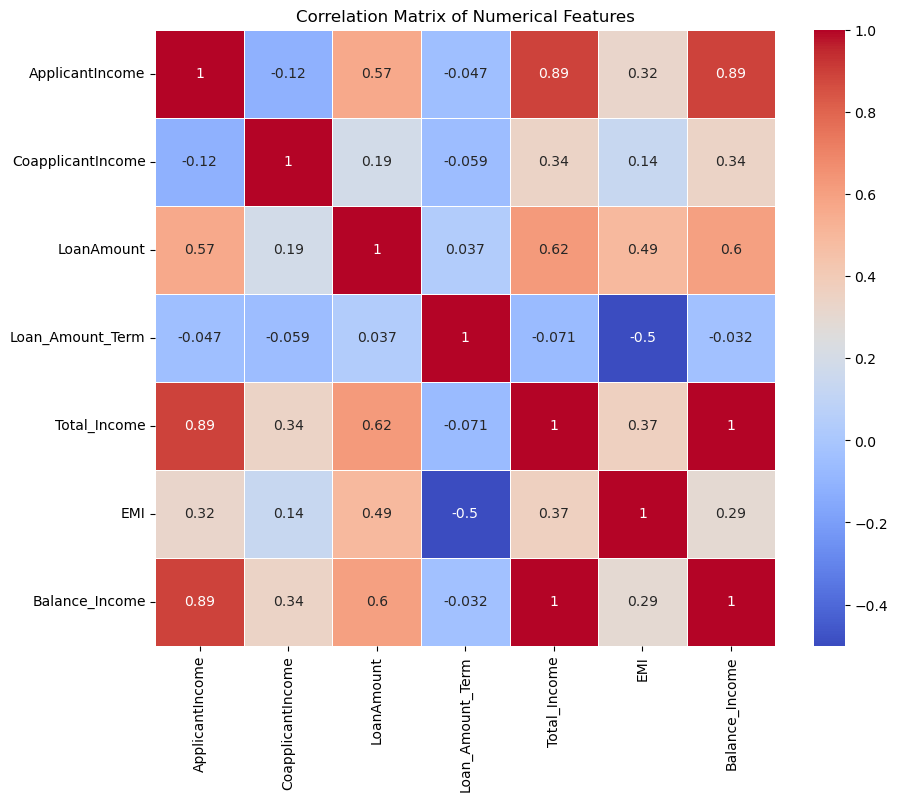

In [13]:
numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 
                  'Loan_Amount_Term', 'Total_Income', 'EMI', 'Balance_Income']

train_corr_df = full_df[full_df['Loan_Status'].notnull()]

corr_matrix = train_corr_df[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

## Separate preprocessed train/test

In [14]:
train_final = full_df[full_df['Loan_Status'].notnull()]
test_final = full_df[full_df['Loan_Status'].isnull()]


## Define features and target

In [15]:
X = train_final.drop(['Loan_ID', 'Loan_Status'], axis=1)
y = train_final['Loan_Status']
X_test_final = test_final.drop(['Loan_ID', 'Loan_Status'], axis=1)


##  Train-test split

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)


In [17]:
num_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 
            'Loan_Amount_Term', 'Total_Income', 'EMI', 'Balance_Income']


In [18]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), num_cols)
    ],
    remainder='passthrough'
)


In [19]:
logreg_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', LogisticRegression(max_iter=500, random_state=42))
])


In [20]:
rf_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

rf_param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [4, 6, None],
    'classifier__min_samples_split': [2, 5],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search_rf = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_search_rf.fit(X_train, y_train)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


d:\Anaconda\envs\tf_env\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         RobustScaler(),
                                                                         ['ApplicantIncome',
                                                                          'CoapplicantIncome',
                                                                          'LoanAmount',
                                                                          'Loan_Amount_Term',
                                                                          'Total_Income',
                                                                          'EMI',
                                                                          'Balance_Income'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [4, 6, None],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [50, 100]},
             scoring='f1', verbose=1)

In [21]:
y_pred_rf = grid_search_rf.predict(X_val)


In [22]:
rf_accuracy = accuracy_score(y_val, y_pred_rf)
rf_precision = precision_score(y_val, y_pred_rf)
rf_recall = recall_score(y_val, y_pred_rf)
rf_f1 = f1_score(y_val, y_pred_rf)

print("Accuracy:", rf_accuracy)
print('Precision: ', rf_precision)
print('Recall: ', rf_recall)
print('F1: ', rf_f1)

Accuracy: 0.8536585365853658
Precision:  0.8383838383838383
Recall:  0.9764705882352941
F1:  0.9021739130434783


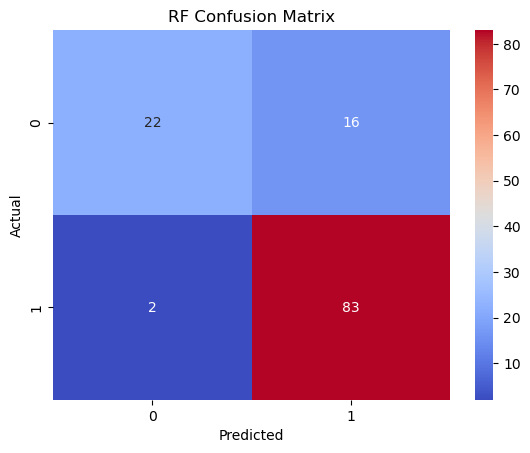

In [23]:
sns.heatmap(confusion_matrix(y_val, y_pred_rf), annot=True, fmt='d', cmap='coolwarm')
plt.title("RF Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

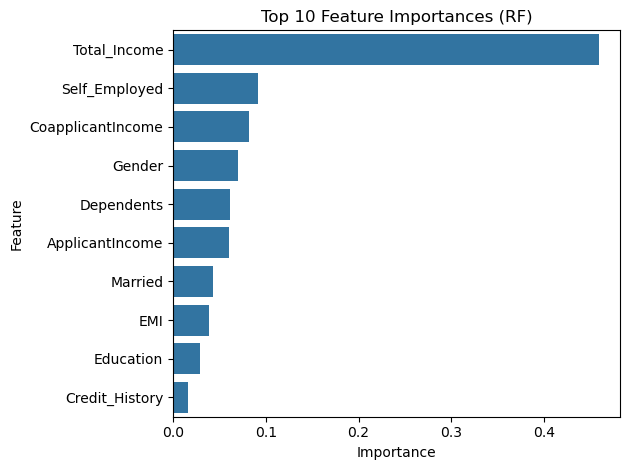

In [24]:
best_rf = grid_search_rf.best_estimator_.named_steps['classifier']
importances = best_rf.feature_importances_
feat_imp_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(10))
plt.title("Top 10 Feature Importances (RF)")
plt.tight_layout()
plt.show()


In [25]:
logreg_pipeline.fit(X_train, y_train)
y_pred_lr = logreg_pipeline.predict(X_val)

In [26]:
lr_accuracy = accuracy_score(y_val, y_pred_lr)
lr_precision = precision_score(y_val, y_pred_lr)
lr_recall = recall_score(y_val, y_pred_lr)
lr_f1 = f1_score(y_val, y_pred_lr)

print("Accuracy:", lr_accuracy)
print('Precision: ', lr_precision)
print('Recall: ', lr_recall)
print('F1: ', lr_f1)

Accuracy: 0.8617886178861789
Precision:  0.84
Recall:  0.9882352941176471
F1:  0.9081081081081082


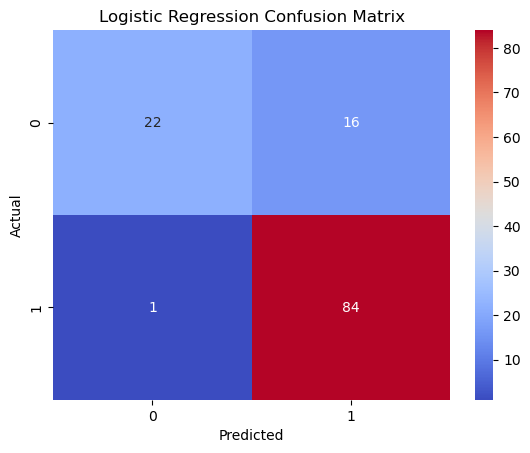

In [27]:
sns.heatmap(confusion_matrix(y_val, y_pred_lr), annot=True, fmt='d', cmap='coolwarm')
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [28]:
df_perf = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [lr_accuracy, rf_accuracy],
    'Precision': [lr_precision, rf_precision],
    'Recall': [lr_recall, rf_recall],
    'F1 Score': [lr_f1, rf_f1]
})
print(df_perf)


                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.861789   0.840000  0.988235  0.908108
1        Random Forest  0.853659   0.838384  0.976471  0.902174


In [29]:
final_test_preds = grid_search_rf.predict(X_test_final)
submission = pd.DataFrame({
    'Loan_ID': test_final['Loan_ID'],
    'Loan_Status': ['Y' if pred == 1 else 'N' for pred in final_test_preds]
})
submission.to_csv('submission.csv', index=False)
